# Part II - Effects of User types, Genders, Cities and Bike sharing options on Bike trip durations
## by Lam Tong

## Investigation Overview

In this investigation, I wanted to look at the factors that could be affect on trip durations. The main focus was on: User types, Genders, Cities and Bike sharing options.


## Dataset Overview

The dataset contains data of 183412 rides in February 2019 of the Ford Gobike bike-sharing system, with 12 detailed info, including: Duration (in seconds/minutes), Start/End time, Start/End Stations data names, City, , Users data (Year of birth, gender), bike sharing options. The added 'city' column tells the city of the station the bike was taken for each ride. The 'member_age' column contains customer ages (at 2019). The duration(h:m:s) column with the duration of each ride in Hours:Minutes:Seconds format.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from geopy.geocoders import Nominatim

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
bikedata = pd.read_csv('fordgobike-tripdata.csv')
#change latitudes, longtitudes to strings:
for coordinate in  ['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']:
    bikedata[coordinate] = bikedata[coordinate].astype(str)
    
#change IDs to strings:
bikedata['start_station_id'].fillna(0,inplace=True)
bikedata['end_station_id'].fillna(0,inplace=True)
for id in ['start_station_id', 'end_station_id', 'bike_id']:
    bikedata[id] = bikedata[id].astype('int64')
    bikedata[id] = bikedata[id].astype(str)
bikedata['start_station_id'] = bikedata['start_station_id'].replace('0', None)
bikedata['end_station_id'] = bikedata['end_station_id'].replace('0', None)

#change member's year of birth to integer:
bikedata['member_birth_year'] = bikedata['member_birth_year'].astype('Int64')

#change start/end time to datetime:
for time in ['start_time', 'end_time']:
    bikedata[time] = bikedata[time].astype('datetime64[ns]')
#Create a 'duration' Column in "hour:minute:second" format:
bikedata['duration(h:m:s)'] = pd.to_datetime(bikedata['duration_sec'], unit='s').dt.strftime('%H:%M:%S')
#Move the 'duration' column to the 2nd position
duration_col = bikedata.pop('duration(h:m:s)')
bikedata.insert(1, 'duration(h:m:s)', duration_col)
#Create a new column of member age (at 2019):
bikedata['member_age'] = 2019 - bikedata['member_birth_year']
#Move the column next to member_birth_year:
age_col = bikedata.pop('member_age')
bikedata.insert(bikedata.columns.get_loc('member_gender'), 'member_age', age_col)
#Create a dataframe of stations:
station = bikedata[['start_station_id','start_station_name','start_station_latitude','start_station_longitude']]
station = station.drop_duplicates()
#Make a Nominatim object and initialize Nominatim API with the geoapiExercises parameter.
geolocator = Nominatim(user_agent="geoapiExercises")
#create a city column for the station:
station['city'] = np.NAN
for index in station.index:
    location = geolocator.reverse((station.loc[index,'start_station_latitude'],station.loc[index,'start_station_longitude']))
    adress = location.raw['address']
    try:
        station.loc[index,'city'] = adress['city']
    except:
        station.loc[index,'city'] = None
station['city'] = station['city'].fillna('Emeryville')
station.loc[(station['start_station_latitude'] == '37.41') & 
            (station['start_station_longitude'] == '-121.96'), 'city'] = 'San Jose'
# Merge the two dataframes based on the latitude and longitude columns
merged_data = pd.merge(bikedata, station, on=['start_station_latitude', 'start_station_longitude'], how='left')
# Update the stations' cities in the bikedata dataframe
bikedata['city'] = np.NaN
bikedata['city'].fillna(merged_data['city'], inplace=True)
#Create the dataset for exploratoration, only keeps the keys data columns:
bikedata_explore = bikedata.drop(['start_station_id','start_station_latitude',
                                          'start_station_longitude','end_station_id',
                                          'end_station_latitude','end_station_longitude',
                                          'bike_id','member_birth_year'],axis=1)
#Move the 'city' column:
city_col = bikedata_explore.pop('city')
bikedata_explore.insert(bikedata_explore.columns.get_loc('start_station_name'), 'city', city_col)
# Convert duration from seconds to minutes
bikedata_explore['Duration_minutes'] = bikedata_explore['duration_sec'] / 60

## Distribution of trip durations

Trip durations in the dataset take on a very large range of values, from about only 1 minute at the lowest, to about 1424 minutes (23 hours and 43 minutes) at the highest. The average duration time is 12.1 minutes. Plotted on a logarithmic scale, the distribution of trip durations takes on a unimodal shape.

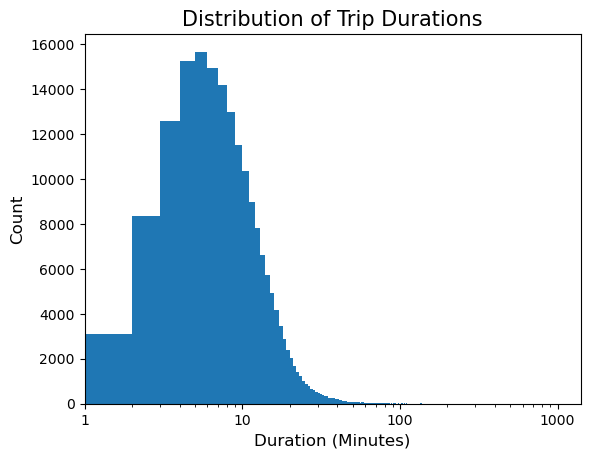

In [3]:
#The Duration distribution in log scale:
bins=np.arange(0,1400,1)
plt.hist(data=bikedata_explore,x='Duration_minutes',bins=bins)
#Log scale
plt.xscale('log')
#Set x limitation and ticks
plt.xlim(1,1400)
x_ticklocs=[1,10,100,1000]
x_ticklabels=['1','10','100','1000']
plt.xticks(x_ticklocs, x_ticklabels)
#Naming labels and titles
plt.xlabel('Duration (Minutes)',size=12)
plt.ylabel('Count',size=12)
plt.title('Distribution of Trip Durations',size=15);

## Number of trips by duration ranges

Most of the trips are less than 15 minutes. While the figure for the trips within 15-30 minutes was 28,564. Trips takes more than 1 hours only hold small percentage of the total figure.

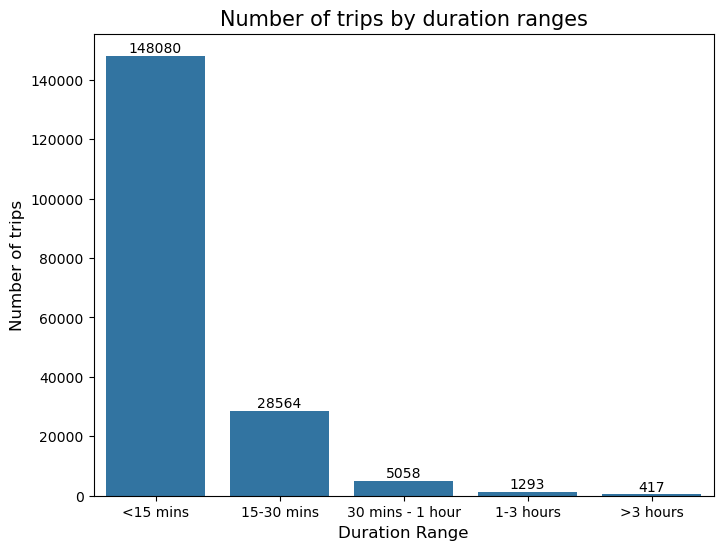

In [4]:
#Base color:
base_color = sb.color_palette()[0]
# Create a new column for duration ranges
bikedata_explore['Duration_Range'] = pd.cut(bikedata_explore['Duration_minutes'], bins=[0, 15, 30, 60, 180, float('inf')], labels=['<15 mins', '15-30 mins', '30 mins - 1 hour', '1-3 hours', '>3 hours'])
# Count the number of occurrences in each range
count = bikedata_explore['Duration_Range'].value_counts()
# Create a count plot
plt.figure(figsize=(8, 6))
sb.barplot(x=count.index, y=count.values,color=base_color)
plt.xlabel('Duration Range',size=12)
plt.ylabel('Number of trips',size=12)
plt.title('Number of trips by duration ranges',size=15)
for i, v in enumerate(count.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show();

## Number of trips in each city

The number of trips in San Francisco was the highest with 133708 trips in Feb 2019. Trips counted in Oakland was 20434 slightly higher than Berkeley counterpart, acounted for 19449 trips. The number of trips in San Jose and Emeryville were 8270 and 1551, respectively.

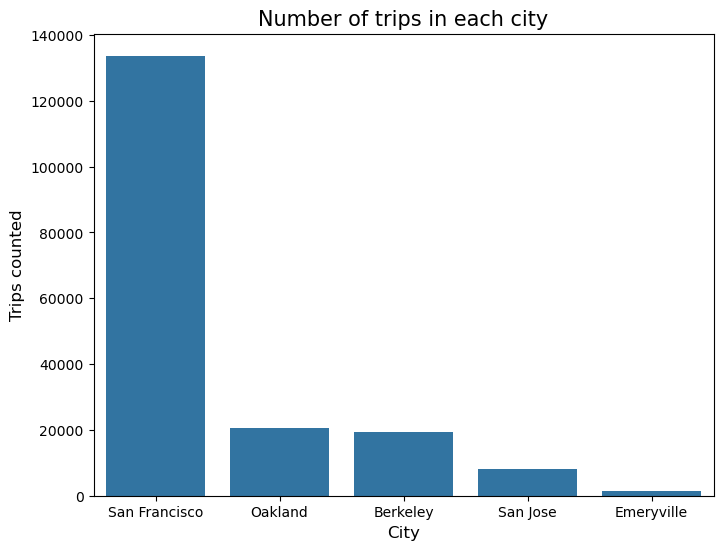

In [5]:
#Correct the city of 2 stations in 'Santa Clara':
bikedata_explore.loc[bikedata_explore['city'] == 'Santa Clara','city'] = 'San Jose'
# Create a countplot
plt.figure(figsize=(8, 6))
order_city = bikedata_explore['city'].value_counts().sort_values(ascending=False).index
sb.countplot(data=bikedata_explore, x='city', color=base_color, order = order_city)
# Display the plot
plt.xlabel('City',size=12)
plt.ylabel('Trips counted',size=12)
plt.title('Number of trips in each city',size=15)
plt.show();

## Number of trips by user types

89.17% of the service are used by Subscribers, as 8 times as much as that of non-subscribers (Customers), with 10.83%

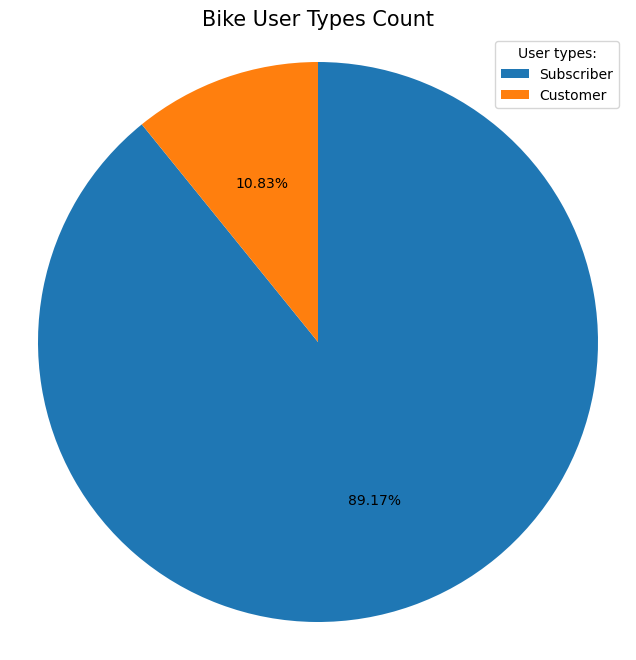

In [6]:
# Show user type by it's percentage
plt.figure(figsize=(8,8))
sorted_counts = bikedata_explore['user_type'].value_counts()
plt.pie(sorted_counts, startangle = 90,
        counterclock = False, autopct='%1.2f%%');
plt.legend(labels = sorted_counts.index,title='User types:')
plt.axis('square')
plt.title('Bike User Types Count', fontsize=15);

## Relation between user types and trips duration

Users who did't subribe had longer trips than subscribers.


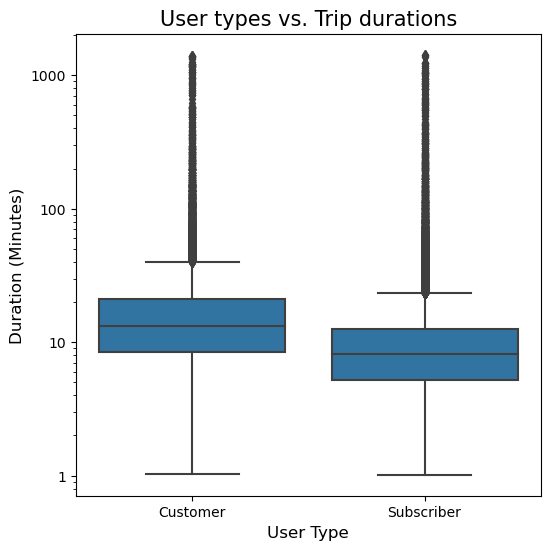

In [7]:
plt.figure(figsize=[6,6])
sb.boxplot(data=bikedata_explore,x='user_type',y='Duration_minutes',color=sb.color_palette()[0])
plt.yscale('log')
y_ticklocs=[1,10,100,1000]
y_ticklabels=['1','10','100','1000']
plt.yticks(y_ticklocs,y_ticklabels)
plt.xlabel('User Type',size=12)
plt.ylabel('Duration (Minutes)',size=12)
plt.title('User types vs. Trip durations',size=15);

## Relation between genders and trips duration

Males have shorter trips than other genders.

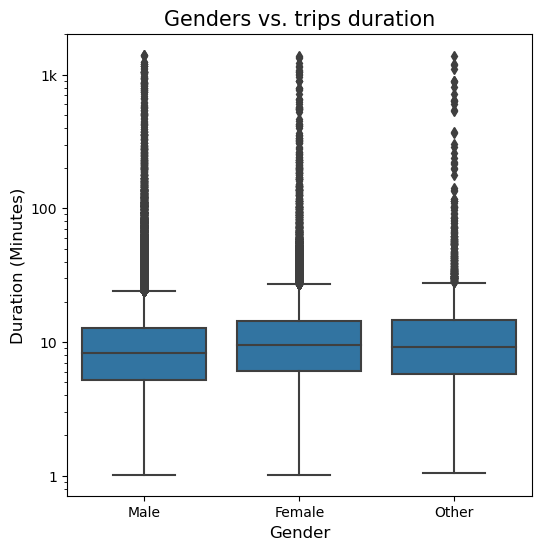

In [8]:
plt.figure(figsize=[6,6])
sb.boxplot(data=bikedata_explore,x='member_gender',y='Duration_minutes',
            color=base_color,order=['Male','Female','Other'])
plt.yscale('log')
y_ticklocs=[1,10,100,1000]
y_ticklabels=['1','10','100','1k']
plt.yticks(y_ticklocs,y_ticklabels)
plt.xlabel('Gender',size=12)
plt.ylabel('Duration (Minutes)',size=12)
plt.title('Genders vs. trips duration',size=15);

## Relation between bike sharing options and trips duration

Trips with bike sharing option were shorter than those were without this option.

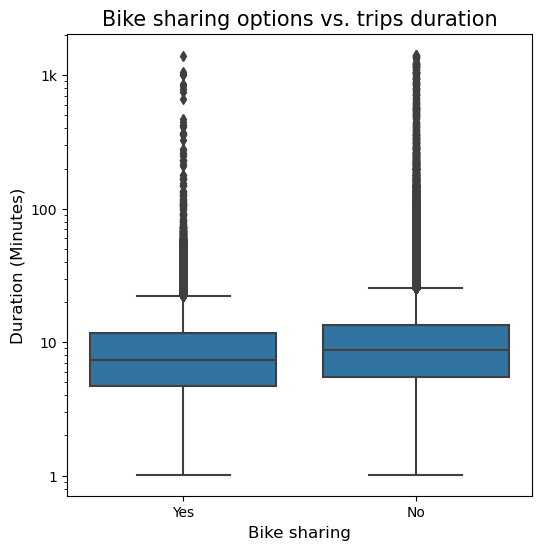

In [9]:
plt.figure(figsize=[6,6])
sb.boxplot(data=bikedata_explore,x='bike_share_for_all_trip',y='Duration_minutes',
            color=base_color,order=['Yes','No'])
plt.yscale('log')
y_ticklocs=[1,10,100,1000]
y_ticklabels=['1','10','100','1k']
plt.yticks(y_ticklocs,y_ticklabels)
plt.xlabel('Bike sharing',size=12)
plt.ylabel('Duration (Minutes)',size=12)
plt.title('Bike sharing options vs. trips duration',size=15);

## Average trips duration each day of Feb-2019, by gender

Female average duration was higher than male counterpart. Male and female daily average trip durations seem to had the similar trends.

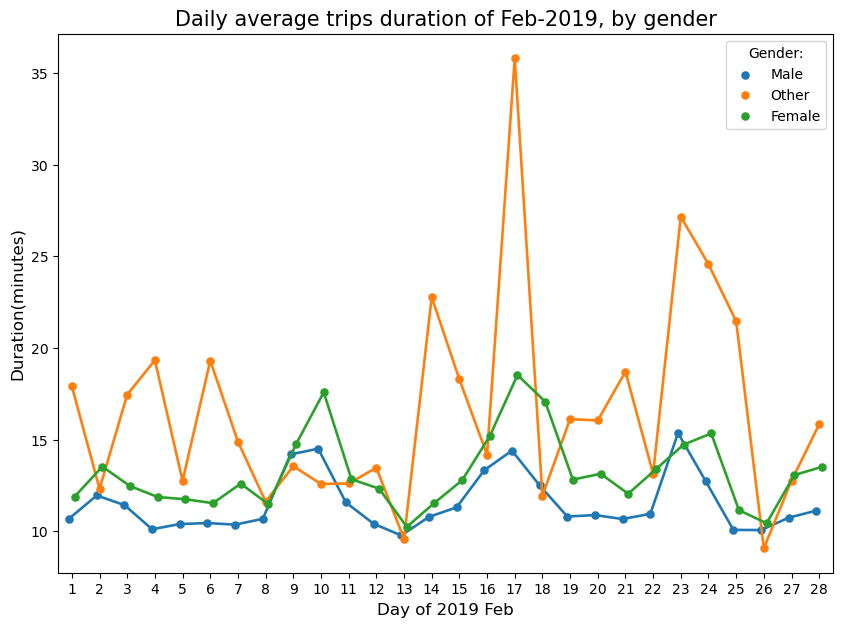

In [10]:
fig = plt.figure(figsize = [10,7])
ax = sb.pointplot(x=bikedata_explore['start_time'].dt.day, 
                  y = bikedata_explore['Duration_minutes'], 
                  hue = bikedata_explore['member_gender'], 
                  errorbar=None,
                  dodge = 0.2,  scale = 0.7)
plt.title('Daily average trips duration of Feb-2019, by gender',size=15)
plt.ylabel('Duration(minutes)',size=12)
plt.xlabel('Day of 2019 Feb',size = 12)
plt.legend(title='Gender:')
plt.show()

## Daily average trips duration of Feb-2019, by subscription status

Though the average trip durations of Customers were higher than Subscriber's. Subscribers tends to have stable duration usage than non-subscribers

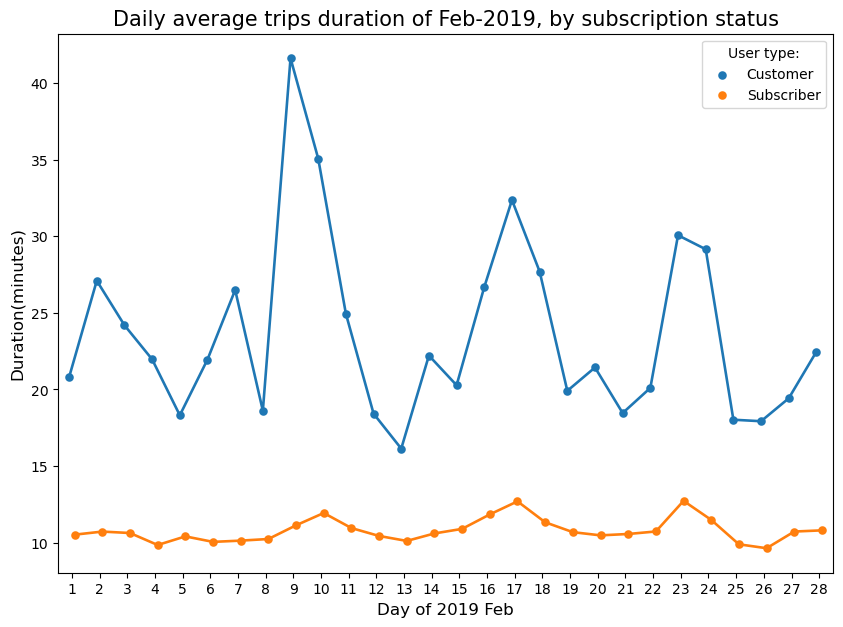

In [11]:
fig = plt.figure(figsize = [10,7])
ax = sb.pointplot(x=bikedata_explore['start_time'].dt.day, 
                  y = bikedata_explore['Duration_minutes'], 
                  hue = bikedata_explore['user_type'], 
                  errorbar=None,
                  dodge = 0.2,  scale = 0.7)
plt.title('Daily average trips duration of Feb-2019, by subscription status',size=15)
plt.ylabel('Duration(minutes)',size=12)
plt.xlabel('Day of 2019 Feb',size = 12)
plt.legend(title='User type:')
plt.show()

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [12]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

'jupyter' is not recognized as an internal or external command,
operable program or batch file.
